导入数据集

In [64]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.metrics import r2_score

In [65]:
train_df = pd.read_csv("C:/Users/Administrator/future/input/train_data.csv",index_col = 0)
test_df = pd.read_csv("C:/Users/Administrator/future/input/test_a.csv",index_col = 0)

In [66]:
train_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


查看数据

In [67]:
#train_df.info()

In [68]:
#train_df.apply(lambda x :np.sum(x.isnull()))

In [69]:
train_df["area"].describe()
"""
area可能需要处理,存在异常值
"""

#train_df["rentType"].value_counts()
"""
rentType"缺失值太多,直接去掉这一列特征
"""

#train_df["houseType"].unique()
"""
"houseType"可能需要提取特征
"""

#train_df["houseFloor"].unique()
"""
"houseFloor"需要将类别型变量转变为数字型变量
"""
#train_df["houseToward"].value_counts()
"""
tradeMoney包含大异常值,需要处理
"""
train_df['tradeMoney'].sort_values(ascending = False).head(10)
'''
totalFloor包含大量异常值,也需要进行处理
'''
train_df['totalFloor'].sort_values(ascending = True).head(10)

train_df['buildYear'].unique()

array(['1953', '2007', '暂无信息', '2003', '2014', '1997', '1993', '1994',
       '1998', '2000', '1995', '1999', '2015', '1981', '2002', '2010',
       '2011', '1989', '1983', '2001', '2012', '1996', '2004', '2006',
       '2009', '2008', '1984', '2017', '1976', '1986', '1988', '1992',
       '2005', '1987', '2016', '1965', '1990', '1985', '1978', '2013',
       '1980', '1954', '1982', '1968', '1940', '1966', '1970', '1937',
       '1979', '1974', '1964', '1991', '1977', '1956', '1930', '1952',
       '1957', '1936', '1967', '1972', '1975', '1955', '1949', '1912',
       '1958', '1973', '1932', '1963', '1931', '1926', '1939', '1951',
       '1960', '1910', '1969', '1920', '1959', '1962', '1961', '1950'],
      dtype=object)

In [70]:
def shaixuan (df):
    df = df[(df["area"]>0)&(df["area"] < 1000)].copy()
    df = df[df["totalFloor"]>0].copy()
    return df

In [71]:
def shaixuan_train (df):
    df = df[(df["tradeMoney"]>0)&(df["tradeMoney"] < 25000)].copy()
    return df

In [72]:
def washdata(df):
    """
    处理houseType
    """
    df["shi"] = df.houseType.astype('str').apply(lambda x:int(x[0:1]))
    df["ting"] =df.houseType.astype('str').apply(lambda x:int(x[2:3]))
    df["wei"] = df.houseType.astype('str').apply(lambda x:int(x[4:5]))
    
    """
    处理houseFloor
    """
    df.loc[df["houseFloor"] == "低","houseFloor"] =1
    df.loc[df["houseFloor"] == "中","houseFloor"] =2
    df.loc[df["houseFloor"] == "高","houseFloor"] =3
    
    """
    处理houseTward,将暂无数据替换为"南"
    """
    df["houseToward"]=df["houseToward"].replace("暂无数据","南")
    #df["houseTward"].value_counts()
    
    """
    将buildYear进行类型转换,转换为int类型,并对缺失值进行填充
    """
    df["buildYear"] = df["buildYear"].replace("暂无信息",0) 
    df["buildYear"] = df["buildYear"].astype(int)
    df["buildYear"] = df["buildYear"].fillna(df["buildYear"].mean())
   
    """
    处理"pv"和"uv"
    """
    df["pv"] = df["pv"].fillna(df["pv"].mean())
    df["uv"] = df["uv"].fillna(df["uv"].mean())
    df["pv_uv"] = df["pv"]/df["uv"]
    
    """
    处理"tradeTime",提取交易年份
    """
    df['tradeYear'] = df.tradeTime.apply(lambda x: int(x.split('/')[0]))
    df['tradeMonth'] = df.tradeTime.apply(lambda x: int(x.split('/')[1]))
    df['build_trade'] =df['tradeYear'] - df['buildYear']
                                           
    #df['rentType']= df['rentType'].replace(['未知方式','整租','合租','--'],[0,1,2,3],inplace=True)
    #df['houseDecoration'].replace([u'其他',u'简装',u'精装','毛坯'],[0,1,2,3],inplace=True)
    #df['houseToward'].replace(['暂无数据','西南','西北','西','南北','南','东西','东南','东','北'],[0,1,2,3,4,5,6,7,8,9],inplace=True)                                       
    #le = preprocessing.LabelEncoder()
    #le.fit(df['communityName'])
    #df['communityName'] = le.transform(df['communityName'])

    #le.fit(df['region'])
    #df['region'] = le.transform(df['region'])

    #le.fit(df['plate'])
    #df['plate'] = le.transform(df['plate'])
    df.loc[df["rentType"] == "--","rentType"] = '未知方式'
    
    #转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')
        
        
    df.drop(['city','houseType','tradeTime','buildYear','tradeYear','tradeLandNum','landTotalPrice','supplyLandNum','landMeanPrice'],axis=1, inplace=True)   
    
    
    return df

In [73]:
#train_df['plate'].value_counts()

In [74]:
#feature = ['area','totalFloor','region','plate','subwayStationNum','busStationNum','interSchoolNum','privateSchoolNum','communityName','bankNum','hospitalNum','parkNum','shopNum','shi','ting','wei','build_trade','pv_uv']

In [75]:
train_1 = shaixuan(train_df)
train_12 =shaixuan_train(train_1)
train_data=washdata(train_12)
train_data.head()

,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,saleSecHouseNum,...,pv,uv,lookNum,tradeMoney,shi,ting,wei,pv_uv,tradeMonth,build_trade
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,1,16,南,其他,XQ00051,RG00001,BK00064,0,...,1124.0,284.0,0,2000.0,2,1,1,3.957746,11,65
100307942,125.55,未知方式,2,14,南,简装,XQ00130,RG00002,BK00049,0,...,701.0,22.0,1,2000.0,3,2,2,31.863636,12,11
100307764,132.00,未知方式,1,32,南,其他,XQ00179,RG00002,BK00050,3,...,57.0,20.0,1,16000.0,3,2,2,2.850000,12,2018
100306518,57.00,未知方式,2,17,南,精装,XQ00313,RG00002,BK00051,0,...,888.0,279.0,9,1600.0,1,1,1,3.182796,12,2018
100305262,129.00,未知方式,1,2,南,毛坯,XQ01257,RG00003,BK00044,1,...,2038.0,480.0,0,2900.0,3,2,3,4.245833,11,2018


In [76]:
#train_data['houseFloor'].dtypes

In [77]:
y_train = train_data.pop("tradeMoney")   #pop相当于这一列全部出去
#train_data.head()

In [78]:
test_1 =shaixuan(test_df)
test_data = washdata(test_1)
test_data.head()

,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,saleSecHouseNum,...,residentPopulation,pv,uv,lookNum,shi,ting,wei,pv_uv,tradeMonth,build_trade
ID,,,,,,,,,,,,,,,,,,,,,
100000079,36.54,未知方式,3,21,西北,其他,XQ03867,RG00012,BK00013,0,...,301635,1601.0,397.0,2,1,1,1,4.032746,10,10
100000138,64.00,未知方式,3,11,南北,其他,XQ00821,RG00002,BK00055,2,...,306857,21123.0,3066.0,0,2,1,1,6.889432,8,9
100000192,98.00,未知方式,3,6,南,精装,XQ00842,RG00002,BK00055,0,...,306857,17471.0,2554.0,0,3,1,1,6.840642,3,22
100000200,43.45,未知方式,3,6,南,其他,XQ00786,RG00002,BK00055,0,...,306857,19231.0,2016.0,0,1,1,1,9.539187,2,24
100000430,92.00,未知方式,3,6,南,其他,XQ01201,RG00002,BK00062,0,...,245872,26189.0,2957.0,0,2,2,1,8.856611,3,14


In [79]:
features = train_data.columns

In [80]:
 categorical_feats = ['rentType', 'houseFloor', 'houseDecoration', 'region', 'plate']     

In [81]:
train_data.houseDecoration.describe()

count     41096
unique        4
top          其他
freq      28805
Name: houseDecoration, dtype: object

train_feature = train_data[feature].copy()
test_feature = test_data[feature].copy()
all_df =pd.concat((train_feature, test_feature), axis=0)
#train_feature.shape[1],test_feature.shape[1]
#train_feature.head()
#train_feature.head()

建立模型

In [82]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.005,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [83]:
folds = KFold(n_splits=10, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train_data))
predictions_lgb = np.zeros(len(test_data))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data.values, y_train.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_data.iloc[trn_idx], label=y_train.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_data.iloc[val_idx], label=y_train.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, 
                    trn_data,
                    num_round, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=500,
                    early_stopping_rounds = 200
                   )
    
    oof_lgb[val_idx] = clf.predict(train_data.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test_data, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(y_train, oof_lgb)))

fold 0


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1050.52	valid_1's rmse: 1073.4
[1000]	training's rmse: 887.499	valid_1's rmse: 967.695
[1500]	training's rmse: 834.108	valid_1's rmse: 948.282
[2000]	training's rmse: 798.058	valid_1's rmse: 939.278
[2500]	training's rmse: 769.855	valid_1's rmse: 934.048
[3000]	training's rmse: 746.967	valid_1's rmse: 930.326
[3500]	training's rmse: 727.351	valid_1's rmse: 928.08
[4000]	training's rmse: 710.807	valid_1's rmse: 927.023
[4500]	training's rmse: 695.225	valid_1's rmse: 925.462
[5000]	training's rmse: 681.274	valid_1's rmse: 924.747
[5500]	training's rmse: 668.929	valid_1's rmse: 924.522
Early stopping, best iteration is:
[5343]	training's rmse: 672.812	valid_1's rmse: 924.251
fold 1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1055.3	valid_1's rmse: 1092.49
[1000]	training's rmse: 891.336	valid_1's rmse: 960.69
[1500]	training's rmse: 837.021	valid_1's rmse: 939.591
[2000]	training's rmse: 800.772	valid_1's rmse: 931.792
[2500]	training's rmse: 772.192	valid_1's rmse: 929.218
[3000]	training's rmse: 748.626	valid_1's rmse: 927.921
Early stopping, best iteration is:
[2965]	training's rmse: 750.115	valid_1's rmse: 927.586
fold 2


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1049.99	valid_1's rmse: 1136.11
[1000]	training's rmse: 886.972	valid_1's rmse: 1009.5
[1500]	training's rmse: 832.842	valid_1's rmse: 981.507
[2000]	training's rmse: 797.395	valid_1's rmse: 969.699
[2500]	training's rmse: 769.218	valid_1's rmse: 963.275
[3000]	training's rmse: 746.519	valid_1's rmse: 959.58
[3500]	training's rmse: 726.136	valid_1's rmse: 957.6
[4000]	training's rmse: 708.512	valid_1's rmse: 956.152
[4500]	training's rmse: 692.916	valid_1's rmse: 954.993
[5000]	training's rmse: 679.071	valid_1's rmse: 953.721
Early stopping, best iteration is:
[5176]	training's rmse: 674.533	valid_1's rmse: 953.013
fold 3


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1050.89	valid_1's rmse: 1152.57
[1000]	training's rmse: 887.725	valid_1's rmse: 1015.91
[1500]	training's rmse: 833.135	valid_1's rmse: 989.614
[2000]	training's rmse: 797.053	valid_1's rmse: 979.188
[2500]	training's rmse: 768.621	valid_1's rmse: 975.044
[3000]	training's rmse: 744.762	valid_1's rmse: 971.712
[3500]	training's rmse: 724.673	valid_1's rmse: 970.766
Early stopping, best iteration is:
[3691]	training's rmse: 717.688	valid_1's rmse: 970.469
fold 4


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1051.21	valid_1's rmse: 1128.74
[1000]	training's rmse: 886.165	valid_1's rmse: 1009.46
[1500]	training's rmse: 830.131	valid_1's rmse: 987.17
[2000]	training's rmse: 793.57	valid_1's rmse: 979.86
[2500]	training's rmse: 764.789	valid_1's rmse: 976.573
[3000]	training's rmse: 741.517	valid_1's rmse: 974.431
[3500]	training's rmse: 721.824	valid_1's rmse: 973.571
Early stopping, best iteration is:
[3558]	training's rmse: 719.826	valid_1's rmse: 973.428
fold 5


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1052.37	valid_1's rmse: 1085.05
[1000]	training's rmse: 888.151	valid_1's rmse: 969.936
[1500]	training's rmse: 834.571	valid_1's rmse: 949.477
[2000]	training's rmse: 798.372	valid_1's rmse: 940.057
[2500]	training's rmse: 770.461	valid_1's rmse: 934.125
[3000]	training's rmse: 747.16	valid_1's rmse: 929.886
[3500]	training's rmse: 727.064	valid_1's rmse: 927.84
[4000]	training's rmse: 710.156	valid_1's rmse: 926.661
Early stopping, best iteration is:
[3969]	training's rmse: 711.116	valid_1's rmse: 926.468
fold 6


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1046.57	valid_1's rmse: 1167.05
[1000]	training's rmse: 883.125	valid_1's rmse: 1043.3
[1500]	training's rmse: 828.401	valid_1's rmse: 1019.35
[2000]	training's rmse: 792.369	valid_1's rmse: 1009.66
[2500]	training's rmse: 763.969	valid_1's rmse: 1004.13
[3000]	training's rmse: 740.901	valid_1's rmse: 1000.77
[3500]	training's rmse: 721.212	valid_1's rmse: 997.505
[4000]	training's rmse: 704.517	valid_1's rmse: 994.761
[4500]	training's rmse: 689.024	valid_1's rmse: 992.887
[5000]	training's rmse: 674.816	valid_1's rmse: 991.691
[5500]	training's rmse: 662.563	valid_1's rmse: 991.125
[6000]	training's rmse: 651.248	valid_1's rmse: 990.585
Early stopping, best iteration is:
[5805]	training's rmse: 655.634	valid_1's rmse: 990.367
fold 7


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1055.24	valid_1's rmse: 1096.47
[1000]	training's rmse: 890.403	valid_1's rmse: 963.896
[1500]	training's rmse: 836.336	valid_1's rmse: 941.183
[2000]	training's rmse: 800.122	valid_1's rmse: 932.681
[2500]	training's rmse: 771.761	valid_1's rmse: 929.214
[3000]	training's rmse: 748.332	valid_1's rmse: 926.241
[3500]	training's rmse: 728.6	valid_1's rmse: 924.339
[4000]	training's rmse: 711.16	valid_1's rmse: 923.506
[4500]	training's rmse: 695.647	valid_1's rmse: 922.709
[5000]	training's rmse: 681.428	valid_1's rmse: 922.115
Early stopping, best iteration is:
[5086]	training's rmse: 679.394	valid_1's rmse: 921.975
fold 8


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1038.33	valid_1's rmse: 1224.21
[1000]	training's rmse: 873.694	valid_1's rmse: 1139.32
[1500]	training's rmse: 819.092	valid_1's rmse: 1121.61
[2000]	training's rmse: 783.587	valid_1's rmse: 1113.2
[2500]	training's rmse: 755.615	valid_1's rmse: 1107.79
[3000]	training's rmse: 732.904	valid_1's rmse: 1105.65
[3500]	training's rmse: 713.589	valid_1's rmse: 1104.2
Early stopping, best iteration is:
[3442]	training's rmse: 715.627	valid_1's rmse: 1104.11
fold 9


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1059.34	valid_1's rmse: 1046.17
[1000]	training's rmse: 894.91	valid_1's rmse: 948.526
[1500]	training's rmse: 839.991	valid_1's rmse: 925.456
[2000]	training's rmse: 803.195	valid_1's rmse: 914.517
[2500]	training's rmse: 773.654	valid_1's rmse: 906.898
[3000]	training's rmse: 749.181	valid_1's rmse: 902.653
[3500]	training's rmse: 728.945	valid_1's rmse: 900.161
[4000]	training's rmse: 711.599	valid_1's rmse: 898.306
[4500]	training's rmse: 696.021	valid_1's rmse: 896.741
[5000]	training's rmse: 681.609	valid_1's rmse: 896.307
Early stopping, best iteration is:
[5100]	training's rmse: 678.931	valid_1's rmse: 895.867
CV Score: 0.90208 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


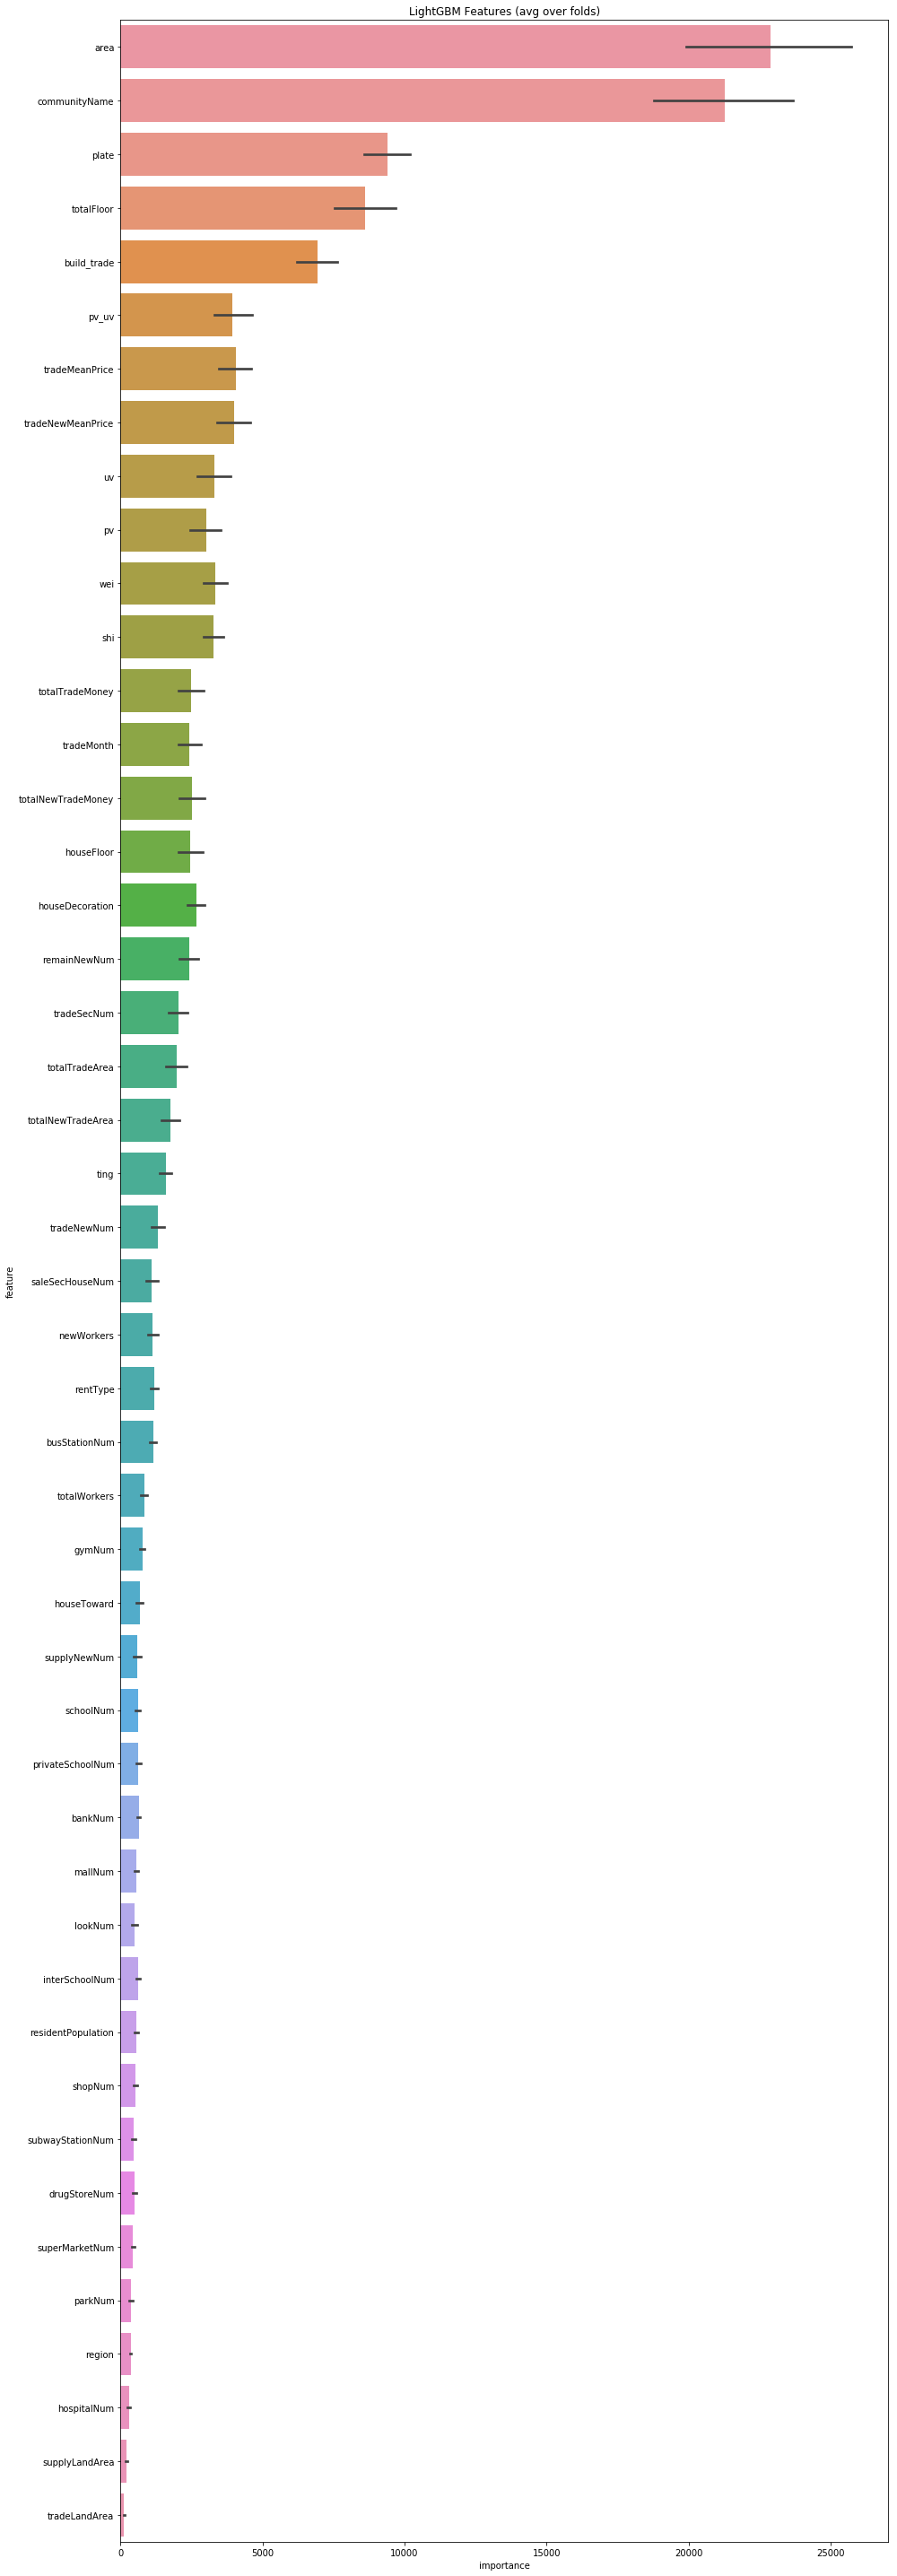

In [84]:
import seaborn as sns
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [85]:
submission_df = pd.DataFrame(data = predictions_lgb).apply(round)
submission_df.to_csv('C:/Users/Administrator/future/output/submit.csv',na_rep='\n',index=False,encoding='utf8',header=False)

In [86]:
submission_df.head(5)

,0
0,3852.0
1,4940.0
2,5602.0
3,3521.0
4,4050.0
